In [1]:
%matplotlib widget

import pinocchio as pin
import numpy as np

from pynocchio import RobotWrapper

import time

In [2]:
import qpsolvers

#
# solvers - 'cvxopt', 'osqp', 'quadprog', 'proxqp'
def solve_qp(A,s,x_min=None,x_max=None, G=None, h=None, grad = None, reg_w=1e-7, solver='quadprog'):
    P = A.T@A
    if grad is not None:
        q = -A.T@s + reg_w*grad[:,None]
        P= P+np.eye(len(grad))*reg_w
    else:
        q = -A.T@s
    if x_max is not None:
        G = np.vstack((-np.identity(len(x_max)),np.identity(len(x_min))))
        h = np.hstack((list(-np.array(x_min)),x_max))
    if G is not None:
        G = np.array(G)
        h = np.array(h)
    return qpsolvers.solve_qp(P, q.flatten(), G,h, solver=solver)

In [3]:
panda = RobotWrapper("panda_link8","panda.urdf")

n = len(panda.q_max)

# limits
# joint space
q_min, q_max  = panda.q_min, panda.q_max
dq_max, dq_min = panda.dq_max, panda.dq_min
t_max, t_min = panda.t_max, panda.t_min
ddq_max = np.array([15,7.5,10,12.5,15,20,20])
ddq_min = -ddq_max
dddq_max = np.array([7500, 3750, 5000,6250,7500,10000,10000])
dddq_min = -dddq_max

# initial pose
q0 = (q_min+q_max)/2
panda.q = q0

# inital pose
X_init = panda.forward(q0).copy()
# final pose
X_final = pin.SE3(X_init.rotation,X_init.translation-np.random.rand(3)*0.3)

# Velocity QP control

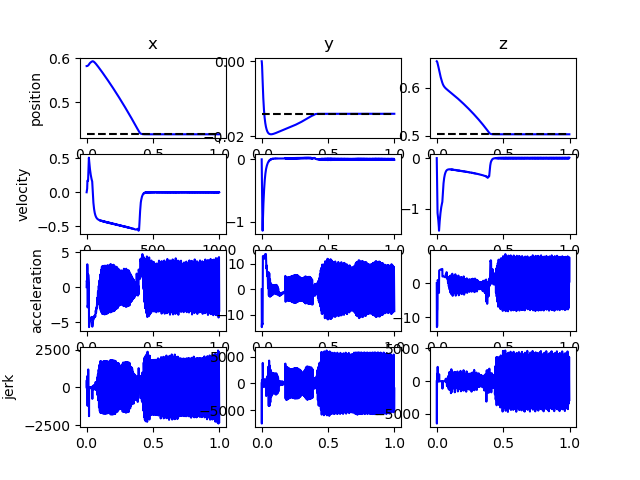

In [7]:
# PD controller parameters
Kp = 100
Kd = 2*np.sqrt(Kp)
# step time
dt = 0.001
# QP horizon 
t_h = 15*dt

# Generate the trajectory within the control loop
s = time.time()

# regularisation positon
q_mean = (q_min+q_max)/2


i=0
q_c = q0
dq_c, ddq_c, dddq_c = np.zeros(n),np.zeros(n),np.zeros(n)

x_list, dx_list, ddx_list,dddx_list = [], [], [], []
while i<1000:    
    i = i+1
    
    # calculate the kinematics
    X_cur = panda.forward(q_c)
    J = panda.jacobian(q_c)
    Jdot = panda.jacobian_dot(q_c,dq_c)
    
    # saving variables for the visualisation
    x_list.append(X_cur.translation.copy())
    dx_list.append(J@dq_c)
    ddx_list.append(J@ddq_c + Jdot@dq_c)
    dddx_list.append(J@dddq_c + Jdot@ddq_c)
    dq_c_old = dq_c.copy()
    ddq_c_old = ddq_c.copy()
    
    # calculating the limits
    dq_ub = np.minimum(
            np.minimum(dq_max, (t_h*ddq_max + dq_c).flatten()), 
            ((q_max - q_c)/t_h).flatten())
    dq_lb = np.maximum(
            np.maximum(dq_min, (t_h*ddq_min + dq_c).flatten()), 
            ((q_min - q_c)/t_h).flatten())
     
    # acceleration pd
    X_log = X_final.actInv(X_cur)
    log_dk = pin.log6(X_log)

    # P controller
    dx_des = Kp*(-(X_final.toActionMatrix()@log_dk)[:,None]) 
    # solve the qp in acceleration
    dq_c = solve_qp(J, dx_des, dq_lb, dq_ub, grad=-(q_mean-q_c), reg_w=50*0.00001, solver='quadprog')    
    
    # simulating the robot
    q_c = np.clip(dq_c*dt + ddq_c*(dt**2)/2 + q_c, q_min,q_max)
    dq_c = dq_c + ddq_c*dt;
    dq_c = np.clip(dq_c, dq_min, dq_max)
    ddq_c = (dq_c - dq_c_old)/dt
    ddq_c = np.clip(ddq_c, ddq_min, ddq_max)
    dddq_c = (ddq_c - ddq_c_old)/dt
    dddq_c = np.clip(dddq_c, dddq_min, dddq_max)
    
    
# time 
t = np.arange(0,len(x_list))*dt
x_fin = X_final.translation


import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 3)
axs[0,0].set_title("x")
axs[0,0].set_ylabel("position")
axs[0,0].plot(t,np.array(x_list)[:,0],'b')
axs[0,0].plot([0,t[-1]],[x_fin[0],x_fin[0]],'k--')
axs[0,1].set_title("y")
axs[0,1].plot(t,np.array(x_list)[:,1],'b')
axs[0,1].plot([0,t[-1]],[x_fin[1],x_fin[1]],'k--')
axs[0,2].set_title("z")
axs[0,2].plot(t,np.array(x_list)[:,2],'b')
axs[0,2].plot([0,t[-1]],[x_fin[2],x_fin[2]],'k--')
axs[1,0].set_ylabel("velocity")
axs[1,0].plot(np.array(dx_list)[:,0],'b')
axs[1,1].plot(t,np.array(dx_list)[:,1],'b')
axs[1,2].plot(t,np.array(dx_list)[:,2],'b')
axs[2,0].set_ylabel("acceleration")
axs[2,0].plot(t,np.array(ddx_list)[:,0],'b')
axs[2,1].plot(t,np.array(ddx_list)[:,1],'b')
axs[2,2].plot(t,np.array(ddx_list)[:,2],'b')
axs[3,0].set_ylabel("jerk")
axs[3,0].plot(t,np.array(dddx_list)[:,0],'b')
axs[3,1].plot(t,np.array(dddx_list)[:,1],'b')
axs[3,2].plot(t,np.array(dddx_list)[:,2],'b')

# Acceleration QP control

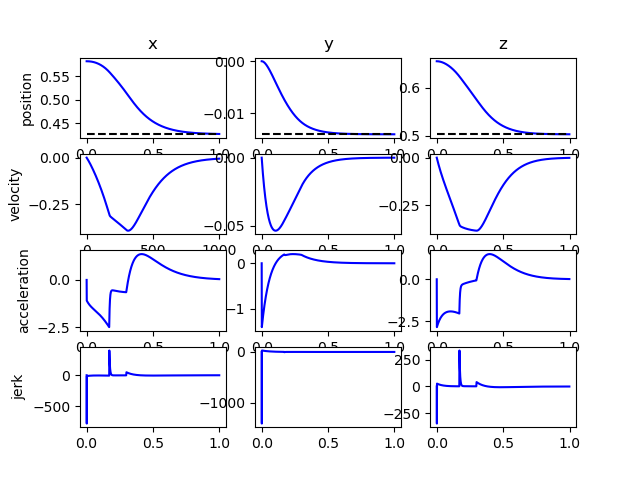

In [5]:
# PD controller parameters
Kp = 100
Kd = 2*np.sqrt(Kp)
# step time
dt = 0.001
# QP horizon 
t_h = 5*dt



# Generate the trajectory within the control loop
s = time.time()

# regularisation positon
q_mean = (q_min+q_max)/2


i=0
q_c = q0
dq_c, ddq_c, dddq_c = np.zeros(n),np.zeros(n),np.zeros(n)

x_list, dx_list, ddx_list,dddx_list = [], [], [], []
while i<1000:    
    i = i+1
    
    # calculate the kinematics
    X_cur = panda.forward(q_c)
    J = panda.jacobian(q_c)
    Jdot = panda.jacobian_dot(q_c,dq_c)
    
    # saving variables for the visualisation
    x_list.append(X_cur.translation.copy())
    dx_list.append(J@dq_c)
    ddx_list.append(J@ddq_c + Jdot@dq_c)
    dddx_list.append(J@dddq_c + Jdot@ddq_c)
    ddq_c_old = ddq_c.copy()
    
    # calculating the limits
    ddq_ub = np.minimum(
        np.minimum(
            np.minimum(ddq_max, (t_h*dddq_max + ddq_c).flatten()), 
            ((dq_max - dq_c)/t_h).flatten()), 
        (2*(q_max - dq_c*t_h - q_c)/t_h**2).flatten())
    ddq_lb = np.maximum(
        np.maximum(
            np.maximum(ddq_min, (t_h*dddq_min + ddq_c).flatten()), 
            ((dq_min - dq_c)/t_h).flatten()), 
        (2*(q_min - dq_c*t_h - q_c)/t_h**2).flatten())
     
    # acceleration pd
    X_log = X_final.actInv(X_cur)
    log_dk = pin.log6(X_log)
    
    # PD controller
    ddx_des = Kp*(-(X_final.toActionMatrix()@log_dk)[:,None]) + Kd*(-J@dq_c)[:,None]
    # removing the J_dot*q_dot
    ddx_des = ddx_des - (Jdot@dq_c)[:,None]
    # solve the qp in acceleration
    ddq_c = solve_qp(J, ddx_des, ddq_lb, ddq_ub, grad=-(q_mean-q_c + 2*(-dq_c)), reg_w=5*0.00001, solver='quadprog')
    
    # simulating the robot
    q_c = np.clip(dq_c*dt + ddq_c*(dt**2)/2 + q_c, q_min,q_max)
    dq_c = dq_c + ddq_c*dt;
    dq_c = np.clip(dq_c, dq_min, dq_max)
    dddq_c = (ddq_c - ddq_c_old)/dt
    dddq_c = np.clip(dddq_c, dddq_min, dddq_max)
    
    
# time 
t = np.arange(0,len(x_list))*dt
x_fin = X_final.translation


import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 3)
axs[0,0].set_title("x")
axs[0,0].set_ylabel("position")
axs[0,0].plot(t,np.array(x_list)[:,0],'b')
axs[0,0].plot([0,t[-1]],[x_fin[0],x_fin[0]],'k--')
axs[0,1].set_title("y")
axs[0,1].plot(t,np.array(x_list)[:,1],'b')
axs[0,1].plot([0,t[-1]],[x_fin[1],x_fin[1]],'k--')
axs[0,2].set_title("z")
axs[0,2].plot(t,np.array(x_list)[:,2],'b')
axs[0,2].plot([0,t[-1]],[x_fin[2],x_fin[2]],'k--')
axs[1,0].set_ylabel("velocity")
axs[1,0].plot(np.array(dx_list)[:,0],'b')
axs[1,1].plot(t,np.array(dx_list)[:,1],'b')
axs[1,2].plot(t,np.array(dx_list)[:,2],'b')
axs[2,0].set_ylabel("acceleration")
axs[2,0].plot(t,np.array(ddx_list)[:,0],'b')
axs[2,1].plot(t,np.array(ddx_list)[:,1],'b')
axs[2,2].plot(t,np.array(ddx_list)[:,2],'b')
axs[3,0].set_ylabel("jerk")
axs[3,0].plot(t,np.array(dddx_list)[:,0],'b')
axs[3,1].plot(t,np.array(dddx_list)[:,1],'b')
axs[3,2].plot(t,np.array(dddx_list)[:,2],'b')

# Torque QP control

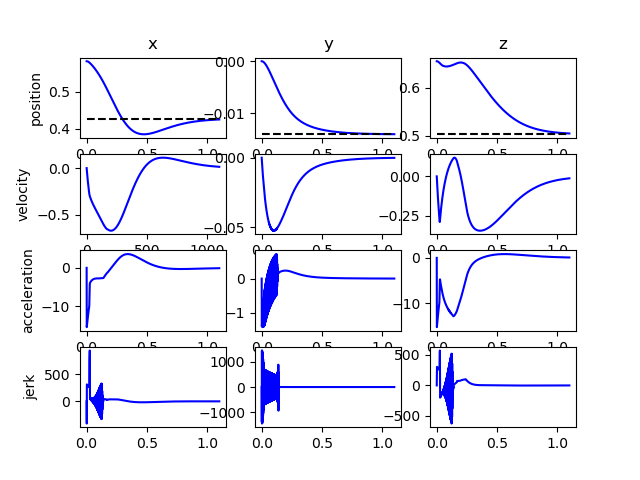

In [6]:
# PD controller parameters
Kp = 100
Kd = 2*np.sqrt(Kp)
# step time
dt = 0.001
# QP horizon 
t_h = 5*dt



# Generate the trajectory within the control loop
s = time.time()

# regularisation positon
q_mean = (q_min+q_max)/2


i=0
q_c = q0
dq_c, ddq_c, dddq_c = np.zeros(n),np.zeros(n),np.zeros(n)

x_list, dx_list, ddx_list,dddx_list = [], [], [], []
while i<1100:    
    i = i+1
    
    # calculate the kinematics
    X_cur = panda.forward(q_c)
    J = panda.jacobian(q_c)
    Jdot = panda.jacobian_dot(q_c,dq_c)
    M = panda.mass_matrix(q_c)
    M_inv =np.linalg.pinv(M)
    g = panda.gravity_torque(q_c)
    
    # saving variables for the visualisation
    x_list.append(X_cur.translation.copy())
    dx_list.append(J@dq_c)
    ddx_list.append(J@ddq_c + Jdot@dq_c)
    dddx_list.append(J@dddq_c + Jdot@ddq_c)
    ddq_c_old = ddq_c.copy()
    
    # calculating the limits
    ddq_ub = np.minimum(
            ((dq_max - dq_c)/t_h).flatten(), 
        (2*(q_max - dq_c*t_h - q_c)/t_h**2).flatten())
    ddq_lb = np.maximum(
            ((dq_min - dq_c)/t_h).flatten(), 
        (2*(q_min - dq_c*t_h - q_c)/t_h**2).flatten())
    
    G = np.vstack((M_inv,-M_inv, np.eye(n),-np.eye(n)))
    h = np.hstack((ddq_ub,-ddq_lb,t_max,-t_min))
        
    # acceleration pd
    X_log = X_final.actInv(X_cur)
    log_dk = pin.log6(X_log)
    
    # PD controller
    ddx_des = Kp*(-(X_final.toActionMatrix()@log_dk)[:,None]) + Kd*(-J@dq_c)[:,None]
    # removing the J_dot*q_dot
    ddx_des = ddx_des - (Jdot@dq_c)[:,None] + J@M_inv@(panda.gravity_torque(q_c) + panda.coriolis_matrix(q_c,dq_c)@dq_c)[:,None]
    # solve the qp in acceleration
    t_c = solve_qp(J@M_inv, ddx_des, G=G, h=h, grad=-M_inv@(q_mean-q_c + 2*(-dq_c)), reg_w=1*0.0001, solver='quadprog')
    
    # simulating the robot
    ddq_c = pin.aba(panda.robot,panda.data,q_c,dq_c,t_c)  
    q_c = np.clip(dq_c*dt + ddq_c*(dt**2)/2 + q_c, q_min,q_max)
    dq_c = dq_c + ddq_c*dt;
    dq_c = np.clip(dq_c, dq_min, dq_max)
    dddq_c = (ddq_c - ddq_c_old)/dt
    dddq_c = np.clip(dddq_c, dddq_min, dddq_max)
    
# time 
t = np.arange(0,len(x_list))*dt
x_fin = X_final.translation


import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 3)
axs[0,0].set_title("x")
axs[0,0].set_ylabel("position")
axs[0,0].plot(t,np.array(x_list)[:,0],'b')
axs[0,0].plot([0,t[-1]],[x_fin[0],x_fin[0]],'k--')
axs[0,1].set_title("y")
axs[0,1].plot(t,np.array(x_list)[:,1],'b')
axs[0,1].plot([0,t[-1]],[x_fin[1],x_fin[1]],'k--')
axs[0,2].set_title("z")
axs[0,2].plot(t,np.array(x_list)[:,2],'b')
axs[0,2].plot([0,t[-1]],[x_fin[2],x_fin[2]],'k--')
axs[1,0].set_ylabel("velocity")
axs[1,0].plot(np.array(dx_list)[:,0],'b')
axs[1,1].plot(t,np.array(dx_list)[:,1],'b')
axs[1,2].plot(t,np.array(dx_list)[:,2],'b')
axs[2,0].set_ylabel("acceleration")
axs[2,0].plot(t,np.array(ddx_list)[:,0],'b')
axs[2,1].plot(t,np.array(ddx_list)[:,1],'b')
axs[2,2].plot(t,np.array(ddx_list)[:,2],'b')
axs[3,0].set_ylabel("jerk")
axs[3,0].plot(t,np.array(dddx_list)[:,0],'b')
axs[3,1].plot(t,np.array(dddx_list)[:,1],'b')
axs[3,2].plot(t,np.array(dddx_list)[:,2],'b')